# 3rd Level Model Structure: Everything (Linking Stages)

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from pyomo import environ as pe
from modules.global_set import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,1)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

# Fixing Redundent Stream Variables

In [10]:
# condenser
model.condenser.VLE_block.n_ave.fix(4)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [11]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

In [12]:
check_DOF(pe,model)

Active Equality Constraints:	 2300
Active Inequality Constraints:	 0
Active Variables:		 2483
Fixed Variables:		 169
DOF:				 14


# Load Operating Parameters

In [13]:
# condenser
model.condenser.P.fix(19)
# model.condenser.T.fix(30+273.15)
model.condenser.T.fix(30+273.15)
# model.condenser.L['out'].fix(2)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(5000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+0.8)-0.01/2)
    model.reactive[j].z['H2'].fix(0.8/(1+0.8)-0.01/2)
    model.reactive[j].z['C30H62'].fix(0.01)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    model.reactive[j].Q_main.fix(0)
    # model.reactive[j].T.setlb(270+273.15)

In [14]:
check_DOF(pe,model)

Active Equality Constraints:	 2300
Active Inequality Constraints:	 0
Active Variables:		 2483
Fixed Variables:		 182
DOF:				 1


In [15]:
model.obj = pe.Objective(expr = model.reactive[1].T ,sense=pe.maximize)

In [16]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['constr_viol_tol'] = 1e-7
# opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

In [17]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [18]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     7381
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  85 -5.1957496e+02 7.60e+00 1.81e+06  -1.0 6.73e+03    -  3.95e-01 4.23e-02h  4
  86 -5.2159662e+02 7.37e+00 2.22e+06  -1.0 6.54e+03    -  5.08e-01 4.88e-02h  4
  87 -5.2270561e+02 7.20e+00 2.66e+06  -1.0 6.33e+03    -  6.95e-01 2.79e-02h  5
  88 -5.2380168e+02 7.03e+00 2.87e+06  -1.0 6.22e+03    -  7.85e-01 2.83e-02h  5
  89 -5.2487280e+02 6.87e+00 2.85e+06  -1.0 6.12e+03    -  4.09e-01 2.83e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.2592292e+02 6.71e+00 2.88e+06  -1.0 6.02e+03    -  9.77e-01 2.83e-02h  5
  91 -5.2695529e+02 6.96e+00 2.81e+06  -1.0 5.92e+03    -  4.09e-01 2.85e-02h  5
  92 -5.2796998e+02 7.20e+00 2.75e+06  -1.0 5.83e+03    -  1.00e+00 2.86e-02h  5
  93 -5.2896758e+02 7.42e+00 2.67e+06  -1.0 5.74e+03    -  4.49e-01 2.87e-02h  5
  94 -5.2995056e+02 7.63e+00 2.60e+06  -1.0 5.66e+03    -  1.00e+00 2.88e-02h  5
  95 -5.4542553e+02 1.09e+02 1.40e+06  -1.0 5.58e+03    -  4.92e-01 4.62e-01w  1
  96 -5.4684301e+02 1.04e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -5.2788506e+02 7.81e-02 7.27e+04  -1.0 6.91e+01    -  1.00e+00 1.00e+00s 22
 181 -5.2786659e+02 1.47e-04 4.51e+04  -1.0 2.96e+00    -  1.00e+00 0.00e+00S 22
 182 -5.2786643e+02 1.13e-08 1.29e+00  -1.0 2.65e-02    -  1.00e+00 1.00e+00h  1
 183 -5.2794706e+02 2.79e-03 4.77e+06  -5.7 1.33e+01    -  5.28e-01 1.00e+00f  1
 184 -5.3163167e+02 5.86e+00 5.03e+06  -5.7 2.15e+03    -  1.40e-02 2.83e-01f  1
 185 -5.3164938e+02 5.85e+00 2.02e+07  -5.7 1.02e+03    -  1.48e-01 2.92e-03h  1
 186 -5.3232008e+02 5.39e+00 3.63e+07  -5.7 1.02e+03    -  2.68e-01 1.11e-01h  1
 187 -5.3231969e+02 5.33e+00 1.30e+12  -5.7 4.93e-04  15.5 1.32e-03 7.90e-01h  1
 188 -5.3231973e+02 1.24e-03 8.07e+12  -5.7 5.33e+00    -  1.85e-06 1.00e+00h  1
 189 -5.3231973e+02 1.24e-03 8.07e+12  -5.7 4.25e-03  15.0 7.21e-06 2.24e-05h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -5.3308839e+02 2.58e-01

In [19]:
update_dual(pe,model)

In [20]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	       -62.6463024290 	         0.3852659056 	         0.9188320873
              284.84 	         0.0000000000 	         1.3544914616 	         0.0176176535
----------------------------------------------------------------------------------------------------
Top
V	 0.3852659055951892
L	 0.0
W	 0.050393478668336364
----------------------------------------------------------------------------------------------------
Bottom
L	 0.017617653459208744
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		1.053%		0.014%		 H2       	0.309%		0.014%
CO 		0.874%		0.025%		 CO       	0.265%		0.014%
CO2 		64.224%		12.478%		 CO2      	26.733%		2.708%
H2O 		0.223%		0.000%		 H2O      	3.784%		0.622%
C2H4 		5.704%		1.781%		 C2H4     	2.831%		0

In [21]:
model.reactive[1].kinetics_block.r_FT_total.value

0.2992746510047286

In [22]:
# model.solutions.store_to(results)
# with open('../saved_solutions/1_stage_condenser_n58_tmp.pickle','wb') as f:
#     pickle.dump(results,f)

### Check non-active constraints (dual = 0)

In [23]:
for i in model.dual:
    if abs(model.dual[i]) == 0:
        print('{:40s}'.format(str(i)),'\t\t',model.dual[i])

condenser.energy_block.dH_F_con[C30H62]  		 0.0
condenser.energy_block.dH_F_con[CO]      		 0.0
condenser.energy_block.dH_F_con[H2]      		 0.0
condenser.energy_block.H_F_con           		 0.0


# Iterative Data Analysis

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
opt.options['linear_solver'] = 'ma86'
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [26]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.condenser.L['out'] ,sense=pe.maximize)
model.reactive[1].T.fixed = True
model.reactive[1].Q_main.fixed = False
model.condenser.L['out'].setlb(0)

In [27]:
check_DOF(pe,model)

Active Equality Constraints:	 2300
Active Inequality Constraints:	 0
Active Variables:		 2483
Fixed Variables:		 182
DOF:				 1


In [28]:
update_dual(pe,model)

In [29]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         F

In [30]:
results_anchor = results

In [31]:
Refluxrange = np.linspace(0,3,20)
Trange = np.linspace(300+273.15,200+273.15,10)

In [32]:
rf_data_master = {}

for t in Trange:
    model.solutions.load_from(results_anchor)
    update_dual(pe,model)
    model.reactive[1].T.fix(t)
    model.condenser.L['out'].setub(0)
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    print('\nWorking on T = {} K'.format(model.reactive[1].T.value))
    print('-'*72)

    rf_data = {}
    rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['Re'] = []; 
    rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []

    for i in model.reactive[1].r_total_comp:
        rf_data['r'][i] = []

    for re in Refluxrange:
        model.condenser.L['out'].fixed = False
        model.condenser.L['out'].setub(re)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        print('Solved\t|Reflux = {:.3f} kmol/s\t|Vapor = {:.3f} kmol/s\t|Distillate = {:.3f} kmol/s\t|Bottom = {:.3f} kmol/s'.\
              format(model.condenser.L['out'].value,model.condenser.V['out'].value,model.condenser.L['P'].value,model.reactive[1].L['out'].value))
        rf_data['T'].append(model.reactive[1].T.value)
        rf_data['Q'].append(model.reactive[1].Q_main.value)
        rf_data['V'].append(model.condenser.V['out'].value)
        rf_data['L'].append(model.condenser.L['P'].value)
        rf_data['Re'].append(model.condenser.L['out'].value)

        for i in model.reactive[1].r_total_comp:
            rf_data['r'][i].append(model.reactive[1].r_total_comp[i].value)


        rf_data['y_H2O'].append(model.reactive[1].y['H2O'].value)
        rf_data['y_CO'].append(model.reactive[1].y['CO'].value)
        rf_data['y_H2'].append(model.reactive[1].y['H2'].value)
        rf_data['y_CO2'].append(model.reactive[1].y['CO2'].value)
        rf_data['r_WGS'].append(model.reactive[1].kinetics_block.r_WGS.value)
        rf_data['r_FT'].append(model.reactive[1].kinetics_block.r_FT_total.value)

    rf_data_master[t] = rf_data


Working on T = 573.15 K
------------------------------------------------------------------------
Solved	|Reflux = 0.408 kmol/s	|Vapor = 0.000 kmol/s	|Distillate = 0.007 kmol/s	|Bottom = 0.010 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.158 kmol/s	|Distillate = 0.001 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.412 kmol/s	|Vapor = 0.191 kmol/s	|Distillate = 0.000 kmol/s	|Bottom

Solved	|Reflux = 0.354 kmol/s	|Vapor = 1.878 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.025 kmol/s
Solved	|Reflux = 0.354 kmol/s	|Vapor = 1.878 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.025 kmol/s
Solved	|Reflux = 0.354 kmol/s	|Vapor = 1.878 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.025 kmol/s

Working on T = 528.7055555555555 K
------------------------------------------------------------------------
Solved	|Reflux = 0.306 kmol/s	|Vapor = 0.000 kmol/s	|Distillate = 0.028 kmol/s	|Bottom = 0.013 kmol/s
Solved	|Reflux = 0.311 kmol/s	|Vapor = 0.158 kmol/s	|Distillate = 0.018 kmol/s	|Bottom = 0.020 kmol/s
Solved	|Reflux = 0.316 kmol/s	|Vapor = 0.316 kmol/s	|Distillate = 0.012 kmol/s	|Bottom = 0.023 kmol/s
Solved	|Reflux = 0.319 kmol/s	|Vapor = 0.474 kmol/s	|Distillate = 0.008 kmol/s	|Bottom = 0.025 kmol/s
Solved	|Reflux = 0.322 kmol/s	|Vapor = 0.632 kmol/s	|Distillate = 0.005 kmol/s	|Bottom = 0.027 kmol/s
Solved	|Reflux = 0.325 kmol/s	|Vapor = 0.789 kmol/s	|Distillate = 0.003 kmo

Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 0.278 kmol/s	|Vapor = 0.085 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.034 kmol/s

Working on T = 484.26111111111106 K
------------------------------------------------------------------------
Solved	|Reflux = 0.280 kmol/s	|Vapor = 0.000 kmol/s	|Distillate = 0.009 kmol/s	|Bottom = 0.024 kmol/s
Solved	|Reflux = 0.286 kmol/s	|Vapor = 0.034 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.031 kmol/s
Solved	|Reflux = 0.286 kmol/s	|Vapor = 0.034 kmol/s	|Distillate = 0.000 km

In [33]:
rf_data_master.keys()

dict_keys([573.15, 562.0388888888889, 550.9277777777778, 539.8166666666666, 528.7055555555555, 517.5944444444444, 506.48333333333335, 495.3722222222222, 484.26111111111106, 473.15])

In [34]:
rf_data = rf_data_master[528.7055555555555]

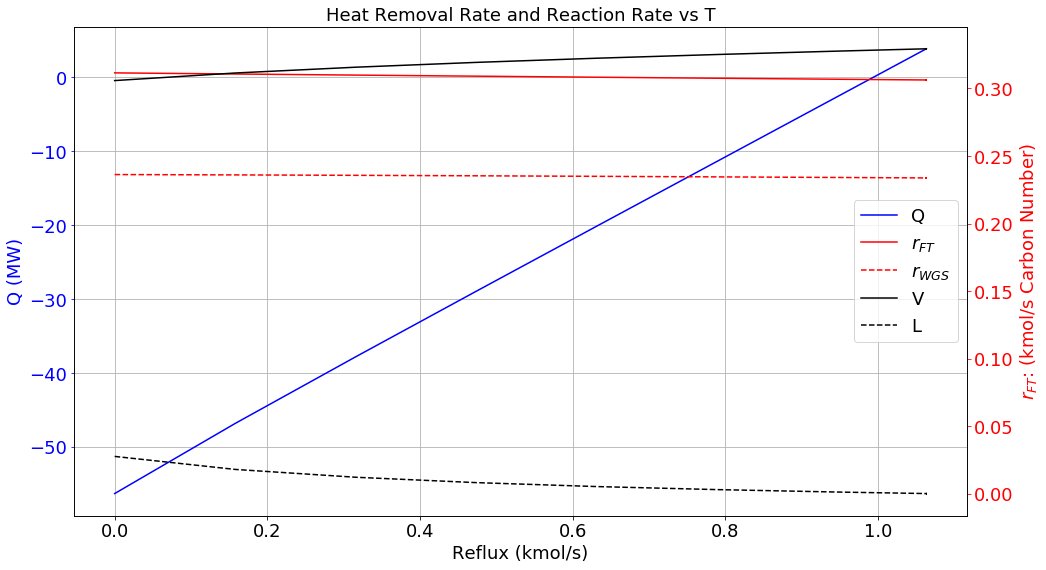

In [35]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['Re'],rf_data['Q'], 'b-')
ax1.set_xlabel('Reflux (kmol/s)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['Re'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['Re'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['Re'],rf_data['V'], 'k-')
line5 = ax2.plot(rf_data['Re'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

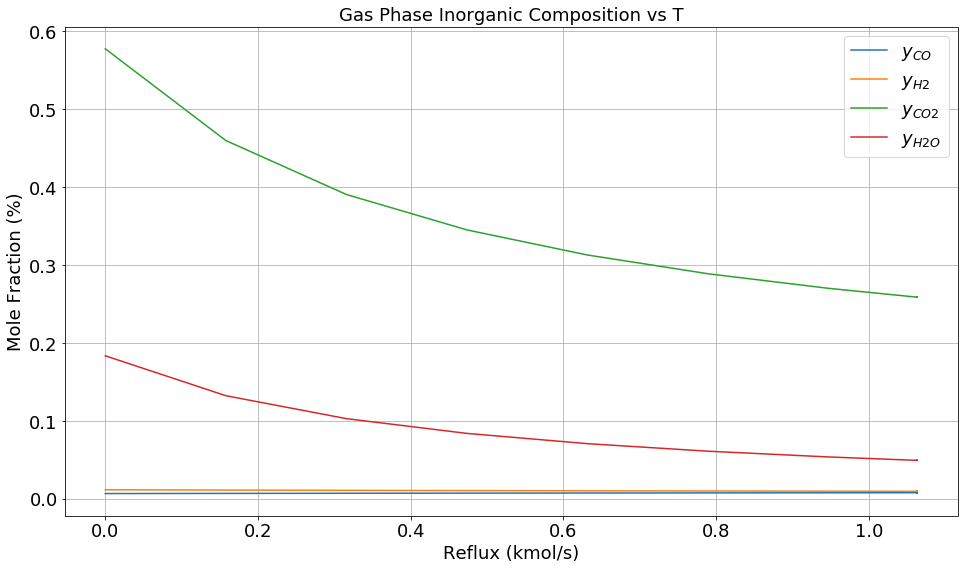

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['Re'],rf_data['y_CO'])
ax.plot(rf_data['Re'],rf_data['y_H2'])
ax.plot(rf_data['Re'],rf_data['y_CO2'])
ax.plot(rf_data['Re'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Reflux (kmol/s)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

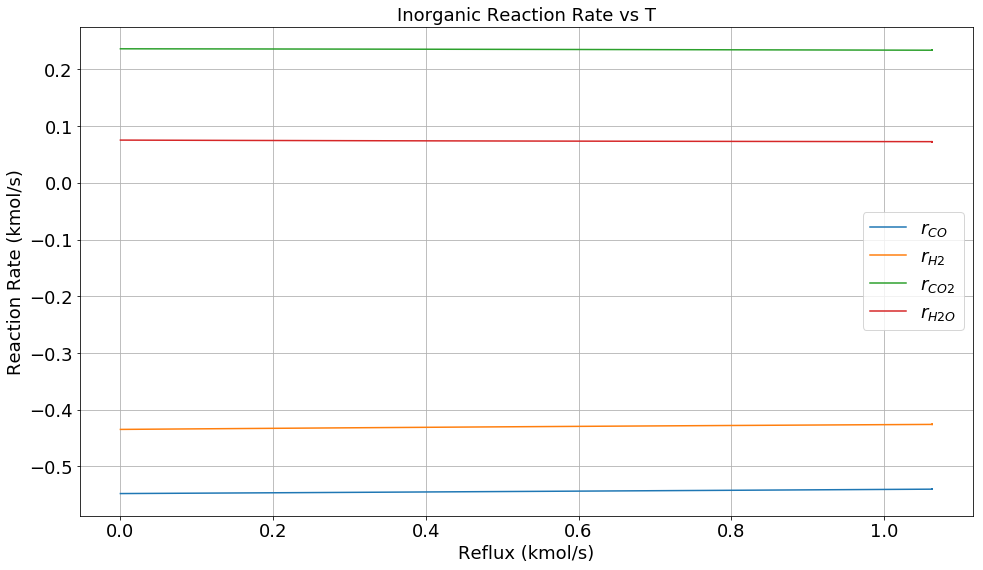

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['Re'],rf_data['r']['CO'])
ax.plot(rf_data['Re'],rf_data['r']['H2'])
ax.plot(rf_data['Re'],rf_data['r']['CO2'])
ax.plot(rf_data['Re'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Reflux (kmol/s)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

In [38]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

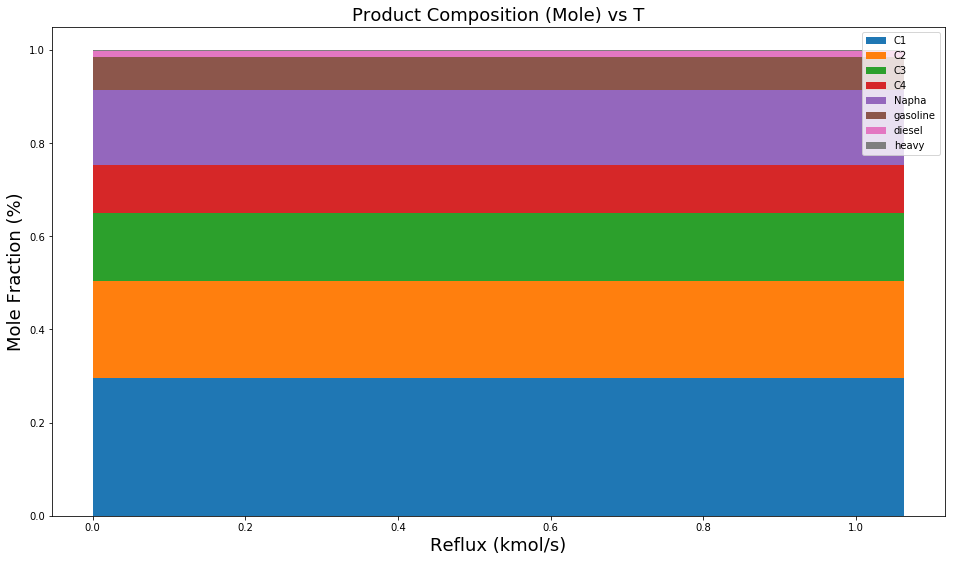

In [39]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['Re'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Reflux (kmol/s)', color='K',fontsize=18)
plt.show()

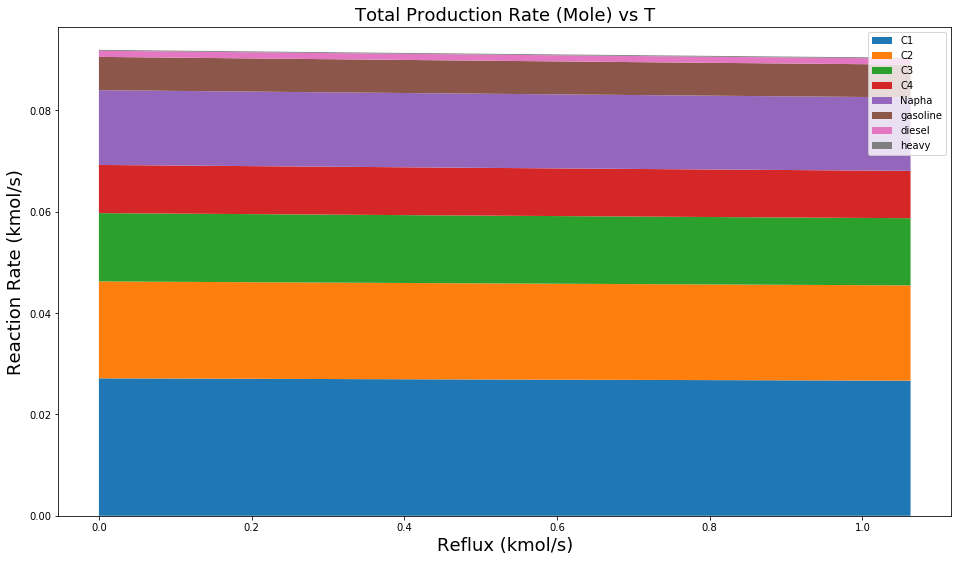

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['Re'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Reflux (kmol/s)', color='K',fontsize=18)
plt.show()

In [41]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

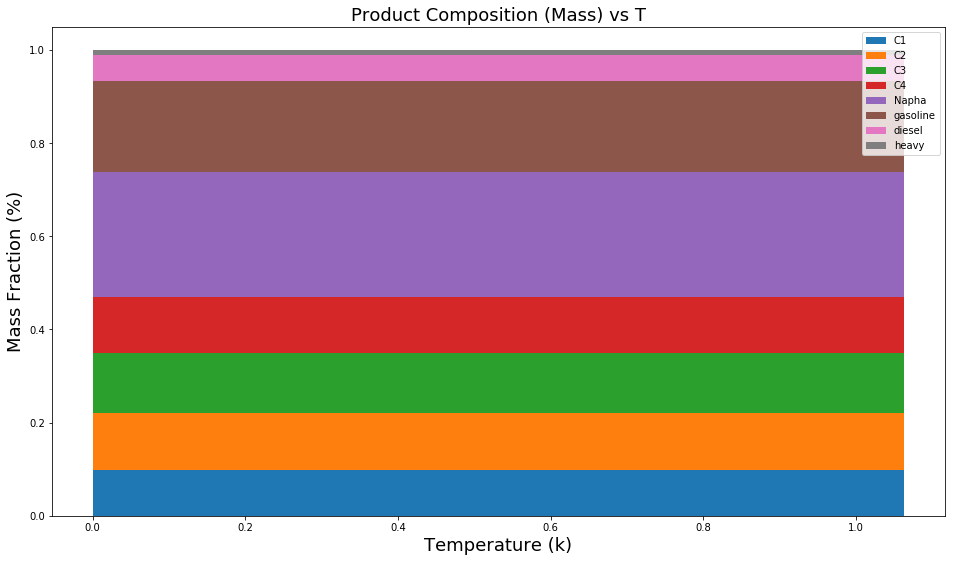

In [42]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['Re'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

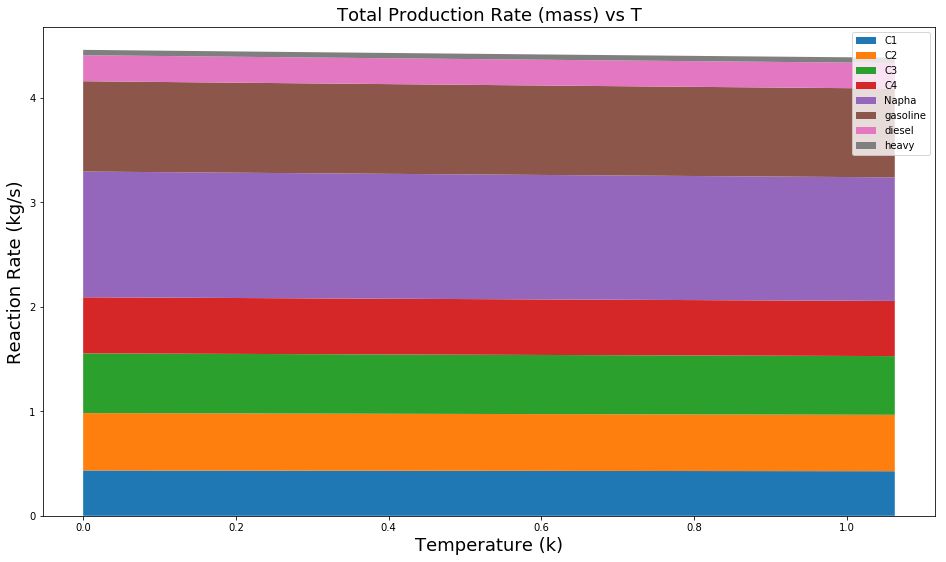

In [43]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['Re'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [44]:
model.reactive[1].kinetics_block.alpha.pprint()

alpha : Size=1, Index=None
    Key  : Lower              : Value              : Upper              : Fixed : Stale : Domain
    None : 0.4207021448830855 : 0.9384067051682439 : 1.0322473756850683 : False : False : PositiveReals
